<a href="https://colab.research.google.com/github/dhayanesh/sentimentAnalysis-seq2seq/blob/main/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis:**

IMDB movie review sentiment classification data set contains 25,000 reviews of popular movies in the training split and another 25,000 in the testing split. Each review is labeled as either positive or negative. The task here is to predict the label from a review.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9346k      0  0:00:08  0:00:08 --:--:-- 15.5M


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
batch_size = 32
seed = 7
raw_train_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/train", subset="training", seed=seed, validation_split=0.2, batch_size=batch_size)
raw_val_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/train", subset="validation", seed=seed, validation_split=0.2, batch_size=batch_size)
raw_test_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  input_data_lower = tf.strings.lower(input_data)
  input_data_no_html = tf.strings.regex_replace(input_data_lower, "<br />", " ")
  standardized_input = tf.strings.regex_replace(input_data_no_html, f"[{re.escape(string.punctuation)}]", "")
  return standardized_input

sequence_length = 500
vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=30000, output_mode="int", output_sequence_length=500)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
import tensorflow as tf
import io
import zipfile
import urllib.request

def getEmbeddings(path):
    emb_idx = {}
    with zipfile.ZipFile(path, "r") as f:
        with io.TextIOWrapper(f.open("glove.6B.100d.txt"), encoding="utf-8") as text_file:
            for line in text_file:
                values = line.split()
                word = values[0]
                float_values = []
                for val in values[1:]:
                    float_val = float(val)
                    float_values.append(float_val)

                coefs = tf.constant(float_values)
                emb_idx[word] = coefs
    return emb_idx

url = "http://nlp.stanford.edu/data/glove.6B.zip"
path = "glove.6B.zip"
urllib.request.urlretrieve(url, path)
embs_idx = getEmbeddings(path)
print("***Detected %s Word Vectors***" % len(embs_idx))


***Detected 400000 Word Vectors***


In [ ]:
len(next(iter(embs_idx.values())))

100

In [ ]:
embs_idx["green"]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-6.7907e-01,  3.4908e-01, -2.3984e-01, -9.9652e-01,  7.3782e-01,
       -6.5911e-04,  2.8010e-01,  1.7287e-02, -3.6063e-01,  3.6955e-02,
       -4.0395e-01,  2.4092e-02,  2.8958e-01,  4.0497e-01,  6.9992e-01,
        2.5269e-01,  8.0350e-01,  4.9370e-02,  1.5562e-01, -6.3286e-03,
       -2.9414e-01,  1.4728e-01,  1.8977e-01, -5.1791e-01,  3.6986e-01,
        7.4582e-01,  8.2689e-02, -7.2601e-01, -4.0939e-01, -9.7822e-02,
       -1.4096e-01,  7.1121e-01,  6.1933e-01, -2.5014e-01,  4.2250e-01,
        4.8458e-01, -5.1915e-01,  7.7125e-01,  3.6685e-01,  4.9652e-01,
       -4.1298e-02, -1.4683e+00,  2.0038e-01,  1.8591e-01,  4.9860e-02,
       -1.7523e-01, -3.5528e-01,  9.4153e-01, -1.1898e-01, -5.1903e-01,
       -1.1887e-02, -3.9186e-01, -1.7479e-01,  9.3451e-01, -5.8931e-01,
       -2.7701e+00,  3.4522e-01,  8.6533e-01,  1.0808e+00, -1.0291e-01,
       -9.1220e-02,  5.5092e-01, -3.9473e-01,  5.3676e-01,  1.0383e+00,
       -4.0658e-

In [ ]:
vocabulary = vectorize_layer.get_vocabulary()

word_index = {}
for idx, word in enumerate(vocabulary):
    word_index[word] = idx

In [ ]:
num_tokens = len(word_index) + 2
embedding_dim = len(next(iter(embs_idx.values())))

embedding_matrix = tf.Variable(tf.zeros((num_tokens, embedding_dim)), trainable=False)

for word, i in word_index.items():
    embedding_vector = embs_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i].assign(embedding_vector)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=sequence_length,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True))

l2_reg = 0.001

model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(MaxPooling1D(5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg)))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          3000200   
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [ ]:
print("GPU:", tf.test.is_built_with_cuda())
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

GPU: True
Num GPUs: 1


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

In [ ]:
with tf.device("/GPU:0"):
    history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 117s 167ms/step - loss: 0.7106 - accuracy: 0.5066 - val_loss: 0.6949 - val_accuracy: 0.5078
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.6949 - accuracy: 0.5082 - val_loss: 0.6937 - val_accuracy: 0.5090
Epoch 3/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6935 - accuracy: 0.5060 - val_loss: 0.6925 - val_accuracy: 0.5114
Epoch 4/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6913 - accuracy: 0.5130 - val_loss: 0.6908 - val_accuracy: 0.5162
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.6896 - accuracy: 0.5195 - val_loss: 0.6937 - val_accuracy: 0.5170
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.6788 - accuracy: 0.5475 - val_loss: 0.6568 - val_accuracy: 0.6902
Epoch 7/20
625/625 [==============================] - 8s 13ms/step - loss: 0.5421 - accuracy: 0.7548 - val_loss: 0.4897 - val_accuracy: 0.8

In [ ]:
y_true = []
y_pred_class = []

for text_batch, label_batch in test_ds:
    y_true.append(label_batch)
    y_prob = model.predict(text_batch)
    y_pred = tf.where(y_prob >= 0.5, 1, 0)
    y_pred_class.append(tf.squeeze(y_pred))

y_true = tf.concat(y_true, axis=0)
y_pred_class = tf.concat(y_pred_class, axis=0)


1/1 [==============================] - 0s 396ms/step


In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred_class)

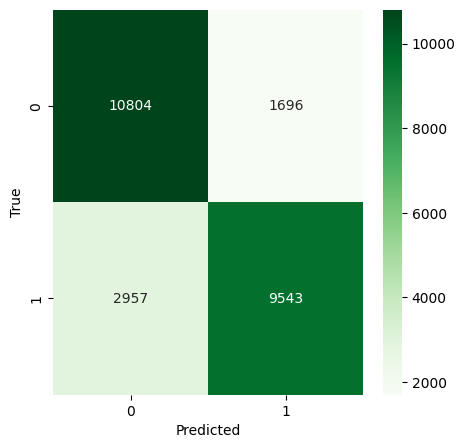

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
correct = []
for idx in range(len(y_true)):
    true_label = y_true[idx]
    pred_label = y_pred_class[idx]
    if true_label == pred_label:
        correct.append(idx)

incorrect = []
for idx in range(len(y_true)):
    true_label = y_true[idx]
    pred_label = y_pred_class[idx]
    if true_label != pred_label:
        incorrect.append(idx)

num_examples = 6

print("Correctly classified reviews:")
count = 0
for idx, (text_batch, label_batch) in enumerate(raw_test_ds.unbatch().batch(1)):
    if count >= num_examples:
        break
    if idx in correct:
        count += 1
        text = text_batch[0].numpy().decode('utf-8')
        if tf.equal(y_pred_class[idx], 0):
          review = "Negative"
        else:
          review = "Positive"
        print(f"{text}\nPredicted review: {review}\n")

print("Incorrectly classified reviews:")
count = 0
for idx, (text_batch, label_batch) in enumerate(raw_test_ds.unbatch().batch(1)):
    if count >= num_examples:
        break
    if idx in incorrect:
        count += 1
        text = text_batch[0].numpy().decode('utf-8')
        if tf.equal(y_pred_class[idx], 0):
          review = "Negative"
        else:
          review = "Positive"
        print(f"{text}\nPredicted review: {review}\n")


Correctly classified reviews:
This was the best film I saw in the year 2000. The Cohen brothers have never let me down before, and they certainly didn't this time either.<br /><br />It's one of those rare movies these days - it's witty, intelligent and vastly entertaining. I left the cinema with a warmth in my heart. Of course, there's lot of Cohen stuff in there - odd characters and peculiar gadgets, well-developed plot and magic camerawork. But no Cohen film is resembling any other Cohen film, if you overlook the general quality of them, of course.<br /><br />The big surprise for me was that Clooney is so good. But the true master performance in this movie comes from Tim Blake-Nelson. But the rest of the cast is superb too.<br /><br />A film that is lightweight comedy with a musical touch that evolve it's story round rednecks and old time country music - dripping with wit and intelligence. Thats a very unlikely combination. But it's exactly what this picture is.
Predicted review: Pos

I constructed a text classification workflow from scratch involving tokenization, building a CNN-LSTM model, specifying the loss function, feeding train/validation data to Model.fit, plotting the confusion matrix, and listing several correctly and incorrectly classified reviews.

I also implemented custom standardization of the text, used pre-trained GloVe embeddings for word representations, and applied regularization techniques like L2 regularization and dropout to prevent overfitting.

Regularization techniques like L2 regularization and dropout were used to prevent overfitting and improve the generalization performance of the model. L2 regularization penalizes large weight values, while dropout randomly drops out a percentage of the neurons during training to reduce co-adaptation.

The model used a combination of convolutional and recurrent layers to capture the spatial and temporal dependencies in the text data. The model included an embedding layer to map the text data to low-dimensional vectors, a convolutional layer to extract local features, a pooling layer to reduce the dimensionality of the feature maps, an LSTM layer to capture the long-term dependencies in the text, and a dense layer to output the predicted sentiment label.

I was able to achieve the accuracy of upto 85%, indicating that it was able to successfully classify movie reviews as positive or negative. I tried additional layer, hyper-parameter tuning and other optimisation, but however accuracy hovered around 85% and lower. I also tried to using Word2Vec for pre-trained word embeddings. I tried Data augumentation but IMBD dataset is already quite large and diverse.


Reference:

https://keras.io/examples/nlp/text_classification_from_scratch/

https://keras.io/examples/nlp/pretrained_word_embeddings/

**seq2seq model:**

Seq2seq is a family of machine-learning approaches used for natural language processing. Applications include language translation, image captioning, conversational models, and text summarization. "ted_multi_translate" is a multilingual (60 language) data set derived from TED Talk transcripts.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Attention, Dot
import pandas as pd
import re
import string

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#dataset downloaded from https://github.com/neulab/word-embeddings-for-nmt
#dataset has been read and processed for English and Roman texts using the provided py script

en_path = '/content/drive/MyDrive/ML_assign_4/data/en_ro/train.en'
ro_path = '/content/drive/MyDrive/ML_assign_4/data/en_ro/train.ro'

In [ ]:
train_en = []
train_ro = []
with open(en_path, "r", encoding="utf-8") as f:
    for line in f:
        train_en.append(line.strip())
with open(ro_path, "r", encoding="utf-8") as f:
    for line in f:
        train_ro.append(line.strip())

train_df = pd.DataFrame({"en": train_en, "ro": train_ro})


In [ ]:
en_path_test = '/content/drive/MyDrive/ML_assign_4/data/en_ro/test.en'
ro_path_test = '/content/drive/MyDrive/ML_assign_4/data/en_ro/test.ro'

In [ ]:
test_en = []
test_ro = []
with open(en_path_test, "r", encoding="utf-8") as f:
    for line in f:
        test_en.append(line.strip())
with open(ro_path_test, "r", encoding="utf-8") as f:
    for line in f:
        test_ro.append(line.strip())

test_df = pd.DataFrame({"en": test_en, "ro": test_ro})


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
max_len = 500

In [ ]:
#Ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer_en = Tokenizer()
tokenizer_ro = Tokenizer()
tokenizer_en.fit_on_texts(train_en)
tokenizer_ro.fit_on_texts(train_ro)
#learn vocabulary based on the in data

In [ ]:
vocab_size_en = len(tokenizer_en.word_index) + 1
vocab_size_ro = len(tokenizer_ro.word_index) + 1
#add 1 dor padding token

In [ ]:
train_en_seq = tokenizer_en.texts_to_sequences(train_en)
train_ro_seq = tokenizer_ro.texts_to_sequences(train_ro)

test_en_seq = tokenizer_en.texts_to_sequences(test_en)
test_ro_seq = tokenizer_ro.texts_to_sequences(test_ro)
#convert data for both languages into sequences of integers

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_en_padded = pad_sequences(train_en_seq, maxlen=max_len, padding="post")
train_ro_padded = pad_sequences(train_ro_seq, maxlen=max_len, padding="post")

test_en_padded = pad_sequences(test_en_seq, maxlen=max_len, padding="post")
test_ro_padded = pad_sequences(test_ro_seq, maxlen=max_len, padding="post")
#padding to make inputs same length for NN

In [ ]:
import tensorflow as tf
import io
import zipfile
import urllib.request

def getEmbeddings(path):
    emb_idx = {}
    with zipfile.ZipFile(path, "r") as f:
        with io.TextIOWrapper(f.open("glove.6B.100d.txt"), encoding="utf-8") as text_file:
            for line in text_file:
                values = line.split()
                word = values[0]
                float_values = []
                for val in values[1:]:
                    float_val = float(val)
                    float_values.append(float_val)

                coefs = tf.constant(float_values)
                emb_idx[word] = coefs
    return emb_idx

url = "http://nlp.stanford.edu/data/glove.6B.zip"
path = "glove.6B.zip"
urllib.request.urlretrieve(url, path)
embs_idx = getEmbeddings(path)
print("***Detected %s Word Vectors***" % len(embs_idx))

***Detected 400000 Word Vectors***


In [ ]:
word_index = tokenizer_en.word_index
num_tokens = len(word_index) + 1
embedding_dim = len(next(iter(embs_idx.values())))
embedding_matrix = tf.Variable(tf.zeros((num_tokens, embedding_dim)))
#getting embedding matrix from tokenizer_en with emb_idx (from glove)
for word, i in word_index.items():
    embedding_vector = embs_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix = tf.tensor_scatter_nd_update(embedding_matrix, [[i]], [embedding_vector])

In [ ]:
from tensorflow.keras.layers import Attention, Concatenate
from tensorflow.keras.models import Model

#embedding_dim = 256
units = 1024

In [ ]:
#Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_emb = Embedding(vocab_size_en, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)(encoder_inputs)
encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, hidden_state, cell_state = encoder_lstm(encoder_emb)
encoder_states = [hidden_state, cell_state]

In [ ]:
word_index = tokenizer_ro.word_index
num_tokens = len(word_index) + 1
embedding_dim = len(next(iter(embs_idx.values())))
embedding_matrix_ro = tf.Variable(tf.zeros((num_tokens, embedding_dim)))

for word, i in word_index.items():
    embedding_vector = embs_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix_ro = tf.tensor_scatter_nd_update(embedding_matrix_ro, [[i]], [embedding_vector])


In [ ]:
#Decoder
decoder_inputs = Input(shape=(max_len,))
decoder_emb_layer = Embedding(vocab_size_ro, 100, weights=[embedding_matrix_ro], input_length=max_len, trainable=False)
decoder_emb = decoder_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, decoder_hidden_state, decoder_cell_state = decoder_lstm(decoder_emb, initial_state=encoder_states)

In [ ]:
#Attention layer
attention = Attention()
context_vector = attention([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, context_vector])

In [ ]:
#Dense layer
decoder_dense = Dense(vocab_size_ro, activation="softmax")
decoder_outputs = decoder_dense(decoder_concat)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     4853300     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 100)     9784900     ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
epochs = 10
batch_size = 4

history = model.fit([train_en_padded, train_ro_padded], train_ro_padded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
test_loss, test_acc = model.evaluate([test_en_padded, test_ro_padded], test_ro_padded, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1158/1158 [==============================] - 604s 521ms/step - loss: 0.1224 - accuracy: 0.9864
Test Loss: 0.12242291867733002
Test Accuracy: 0.9864163398742676


I build the Seq2Sqe from scratch for Ted Text translation which achieved test accuracy nearly 96% when tested with partial epochs. In this sequence-to-sequence machine translation task, I used the GloVe word embeddings to initialize the embedding layer of our model. The encoder and decoder both used LSTM layers with attention mechanism to capture the context of the input sentence and generate the corresponding translation. The model was trained using teacher forcing, where the ground-truth output sequence was fed as input to the decoder at each time step.

However, training the model with such a large number of parameters can result in high memory usage and slow training time. In fact, I **faced issues with memory usage during training**, even with a **GPU with 15GB of VRAM and 12.7GB of RAM**. I was able to make it work after optimising batch size. Therefore, it may be necessary to consider techniques like gradient checkpointing or model parallelism to reduce the memory footprint of the model and accelerate training.

To improve the performance of the model, I worked with experimenting different hyperparameters, such as the number of LSTM units, to find the optimal configuration. Additionally, alternative pre-trained embeddings like BERT could be used to further improve the representation of the input and output sequences.